## Project CV-1

Задача: Обучить пятиклассовый классификатор изображений

In [45]:
#Загружаем библиотеки

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

import torch
import torchvision
import pytorch_lightning as pl

from torchvision.datasets import ImageFolder
from torchvision.datasets import DatasetFolder
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import functional as F

import random
import os
import inspect


b_s = 4 #batch_size

In [2]:
'''Предобработка'''

#По возможности переносим расчёты на видеокарту
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Отрисовка картинок
def plot_images(dataset, num_samples):
    fig, axes = plt.subplots(1, num_samples, figsize=(12,12))
    
    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title('Person: ' + random_label)
        axes[i].axis('off')     
    return plt.show()
 
#Выводим результаты
def get_visualize():
    plt.figure(figsize=(14, 6))

    plt.subplot(121)
    plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
    plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
    plt.xlabel("Номер эпохи")
    plt.title("Функция потери")

    plt.subplot(122)
    plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
    plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
    plt.xlabel("Номер эпохи")
    plt.title("Точность")

    plt.show()
    print(f' обучение: {max(top1_train)},\n валидация: {max(top1_valid)}')

#Строим предсказания
def model_predict(photo):
    image = Image.open(photo)
    tensor = valid_dataset.transform(image)
    batch = torch.stack([tensor])
    with torch.no_grad():
        output = net_model(batch.to(device)).to("cpu")
    predicted = output.argmax().item()
    display(image)
    return train_dataset.classes[predicted]

### Загружаем данные

In [51]:
#тренировочный датасет
train_dataset = ImageFolder('CV_project1_data/data/train/')
#валидационный датасет
valid_dataset = ImageFolder('CV_project1_data/data/valid/')

In [52]:
print(len(train_dataset),len(valid_dataset))

3000 914


In [53]:
print(train_dataset.classes)
print(valid_dataset.classes)

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']
['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']


In [54]:
train_dataset[1]

(<PIL.Image.Image image mode=RGB size=70x70 at 0x25550EBFD30>, 0)

В имеющемся датасете изображения 5-ти известных людей, размер картинок - 70*70. Для тренировки представлены 3000 изображений, 914 оставлены на валидацию 

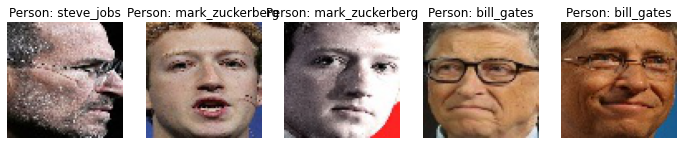

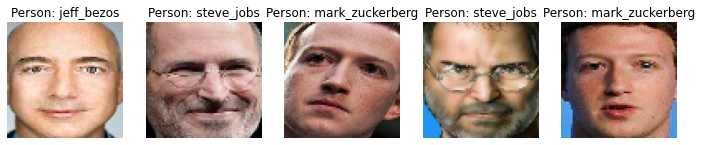

In [55]:
#Посмотрим на изображения в датасетах
plot_images(train_dataset, 5)
plot_images(valid_dataset, 5)

In [56]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

#Аугментация
train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(70),
    transforms.RandomGrayscale(0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset.transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(70),
    transforms.ToTensor(),
    normalize
])

#Загрузим картинки в DataLoader
train_loader = torch.utils.data.DataLoader(
train_dataset, batch_size = b_s, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
valid_dataset, batch_size = b_s, shuffle=True)


train_loader = DataLoader(train_dataset, batch_size = b_s, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = b_s, shuffle = True)

In [57]:
for images, targets in tqdm(train_loader):
    ...

100%|███████████████████████████████████████████████████████████████████████████████| 750/750 [00:03<00:00, 190.98it/s]


### Отрисуем один батч картинок

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['elon_musk', 'steve_jobs', 'steve_jobs', 'jeff_bezos']


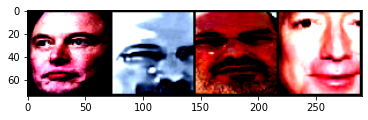

In [60]:
X, y = next(iter(train_loader))
img = torchvision.utils.make_grid(X)
img = img.numpy().transpose((1,2,0))

classes = train_dataset.classes

print([classes[i] for i in y])
plt.imshow(img)

### Выбор модели

Для обучения модели будем использовать предобученную ResNet-50. Она обеспечивает большую точность по сравнению с ResNet-34. При работе с моделями VGG-16 и подобными возникла ошибка памяти видеокарты. Потому выбор остановлен на ResNet-50. 

In [101]:
#Загружаем предобученную модель
net_model = models.resnet50(pretrained=True)

### Рассмотрим структуру ResNet-50

In [62]:
print(net_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

В тренировчном датасете мы имеем 3000 изображений. Будем переобучать несколько последних свёрточных слоёв.

Посмотрим поближе на layer4

In [63]:
print(net_model.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [64]:
#Выходной слой
print(net_model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


### Заморозка весов

Обучать будем 3 последних свёрточных слоя. Они находятся в Bottleneck 2.
Остальные веса нейросети будем замораживать. В финальном слое заменим количество выходов с 1000 на 5.

In [102]:
#ResNet-50 transfer learning
#Сначала заморозим все веса сети

for parameter in net_model.parameters():
    parameter.requres_grad = False
    
#А теперь разморозим веса в Bottleneck 2        

#block = [1,2]

#for i in block:
for parameter in net_model.layer4[2].parameters():
    parameter.requres_grad = True

#Количество выходов классификатора
net_model.fc = torch.nn.Linear(2048, len(train_dataset.classes))

In [103]:
#Проверка финального слоя
net_model.fc

Linear(in_features=2048, out_features=5, bias=True)

### Обучение модели

In [104]:
#Функция потерь для обучения классификации — кроссэнтропия
criterion = torch.nn.CrossEntropyLoss()
#Переносим вычисления на видеокарту
net_model = net_model.to(device)
criterion = criterion.to(device)

In [105]:
#Проверим доступность видеокарты
device

device(type='cuda')

In [106]:
optimizer = torch.optim.SGD(net_model.parameters(), lr=1e-2, weight_decay=1e-4)

In [107]:
def train_model(net, optimizer, train_dataset, valid_dataset, num_epochs):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        # переключаем torch в режим сохрания данных для рассчета градиентов
        torch.set_grad_enabled(True)
        # переключаем модель в режим обучения для хранения промежуточной информация
        net.train()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(train_loader)):
            # переносим на видеокарту
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # делаем шаг обновления весов модели
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # для валидации градиенты не нужны
        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации
        net.eval()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(valid_loader)):
            # переносим на видеокарту
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # шаг обновления весов здесь не нужен
            ...

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

Считаем на 30 эпохах

In [108]:
loss_train, top1_train, loss_valid, top1_valid = train_model(net_model, optimizer, train_dataset, valid_dataset, 30)

100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:04<00:00, 53.02it/s]


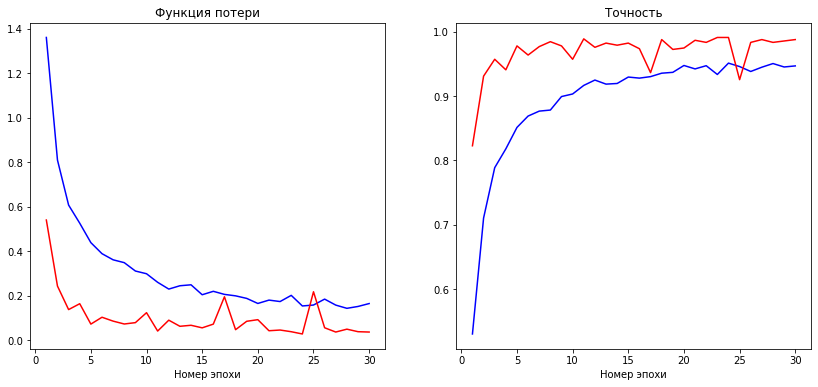

 обучение: 0.9513333333333334,
 валидация: 0.9912472647702407


In [61]:
get_visualize()

#Переобучаем BasicBlock 1&2 в сети ResNet34

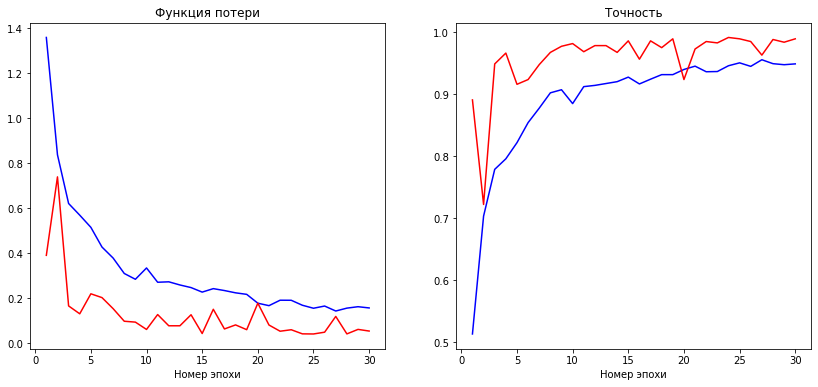

 обучение: 0.9553333333333334,
 валидация: 0.9912472647702407


In [96]:
get_visualize()

#Переобучаем bottleneck 1&2 в layer4 сети ResNet50

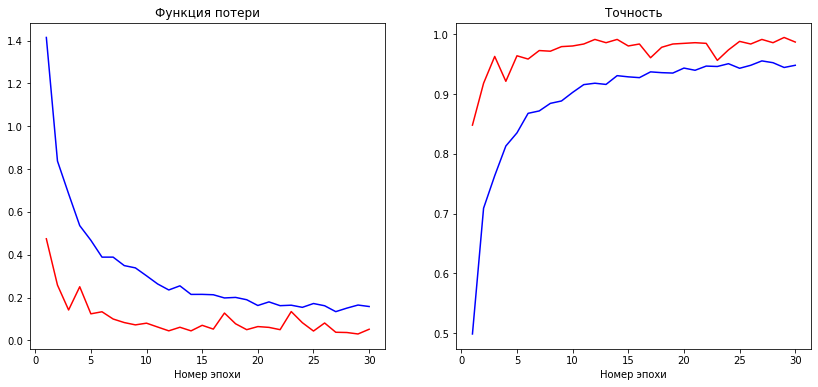

 обучение: 0.9553333333333334,
 валидация: 0.9945295404814004


In [72]:
get_visualize()

#Переобучаем bottleneck 2 в layer4 сети ResNet50

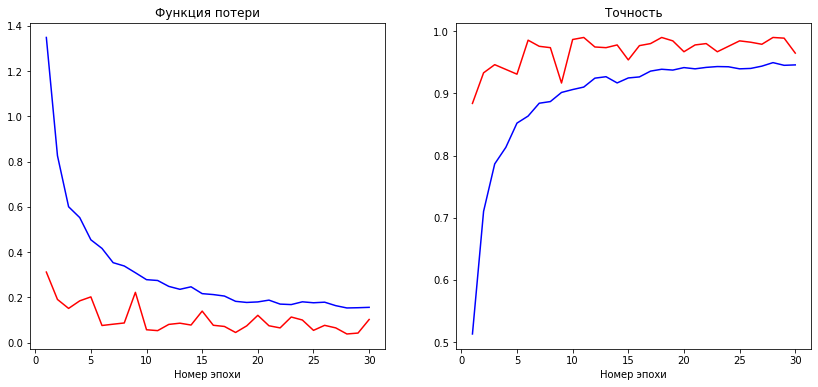

 обучение: 0.9496666666666667,
 валидация: 0.9901531728665208


In [109]:
get_visualize()

#Полностью переобучен слой layer4 в сети ResNet50

In [84]:
# Сохраним модель
torch.save(net_model, 'model.pth')

### Проверим работоспособность модели



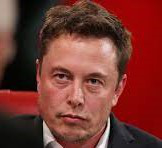

'elon_musk'

In [110]:
model_predict('Musk.jpg')

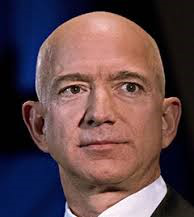

'jeff_bezos'

In [111]:
model_predict('Jeff.jpg')

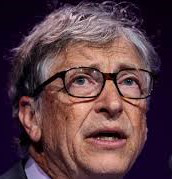

'bill_gates'

In [112]:
model_predict('Gates.jpg')

### Вывод

В имеющемся для обучения датасете 3000 изображений. Этого явно недостаточно для обучения модели "с нуля".
Поэтому для классификации изображения использовалась предобученная нейросеть ResNet50. При этом, чем больше слоёв мы будем переобучать, тем хуже результаты мы получим. Размер нашего датасета явно не сравнится с тем количеством данных, на которых была обучена ResNet-50.

В итоге переобучению были подвергнуты три последних свёрточных слоя Bottleneck2 в блоке layer4 и выходной слой.

Полученная модель очень хорошо показала себя на валидационном датасете с результатом 0,9945. 